# Objective

The objective of this otebook is to explain and see an application of **Partial Dependence Plots (PDP)** and **Individual Conditional Excpectation (ICE)**.

# Partial Dependence Plots (PDP)

It is a visualization technique that shows how a feature impacts the outcome variable. The partial dependence function marginalizes over the feature distribution in set C:

$$ f_{x_S}(x_S) = \mathbb{E}_{x_C} [f(x_s, x_C]$$

It therefore computes the marginal effect of $x_S$ on the prediction. 

A major assumption of the PDP is that features in $x_S$ and $x_C$ are independent and thus uncorrelated.

It can be seen as the average model prediction change when a particular variable changes.

# Individual Conditional Expectation (ICE)

ICE plots visualize the functional relationship between the predicted response and the feature separately for each instance. In other words, a PDP averages the individual lines of an ICE plot. each line represents one instance and visualizes the effect of varying the feature value $x_S^{(i)}$ (Age) of a particular instance on the model’s prediction, given all other features remain constant (c.p.).

More formally, ICE plots can be derived by considering the estimated response function $\hat{f}$ and the observations $(x_S^{(i)}, x_C^{(i)})_{i = 1}^{N}$. The curve $\hat{f}_S$ is plotted against the observed values of $x_S^{(i)}$ for each of the observed instances while $x_C^{(i)}$ remains fixed at each point on the x-axis.

# Libraries

In [27]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Model interpretability
from pdpbox import pdp, get_dataset, info_plots

# Fectching Data

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


# Data processing

Creating a new feature from the name: Try to catch specific titles attached to people

In [4]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [5]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [6]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)

Drop PassengerID and Name features

In [7]:
df = df.drop(['Name', 'PassengerId'], axis=1)

Drop Ticket and Cabbin features

In [8]:
df = df.drop(["Ticket", "Cabin"], axis=1)

Change sex feature into categorical one

In [9]:
df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

Fillna values for Embarked and Age features. For Embarked, we fill missing values with the most common value and for Age, we fill missing values with the median

In [10]:
df['Embarked'] = df['Embarked'].fillna('S')

In [11]:
df['Age'].fillna(df['Age'].dropna().median(), inplace=True)

Encode embarked as categorical

In [12]:
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

Fillna for fare value with median

In [13]:
df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)

# Build predictive model

Split into training and testing set

In [14]:
Y = df["Survived"]
X = df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title"]]

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

Build model

In [16]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Predict test data

In [17]:
Y_pred = random_forest.predict(X_test)

In [18]:
print("Training accuracy: {0}%".format(round(random_forest.score(X_train, Y_train)*100,2)))

Training accuracy: 98.6%


In [19]:
print("Testing accuracy: {0}%".format(round(accuracy_score(Y_test, Y_pred)*100,2)))

Testing accuracy: 82.68%


In [20]:
cm = confusion_matrix(Y_test, Y_pred)
pd.DataFrame(cm)

,0,1
0,102,15
1,16,46


# Explain and verify my model

### Global considerations

In [21]:
importances = random_forest.feature_importances_
indices = np.argsort(importances)

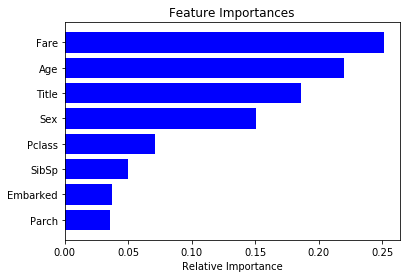

In [22]:
plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

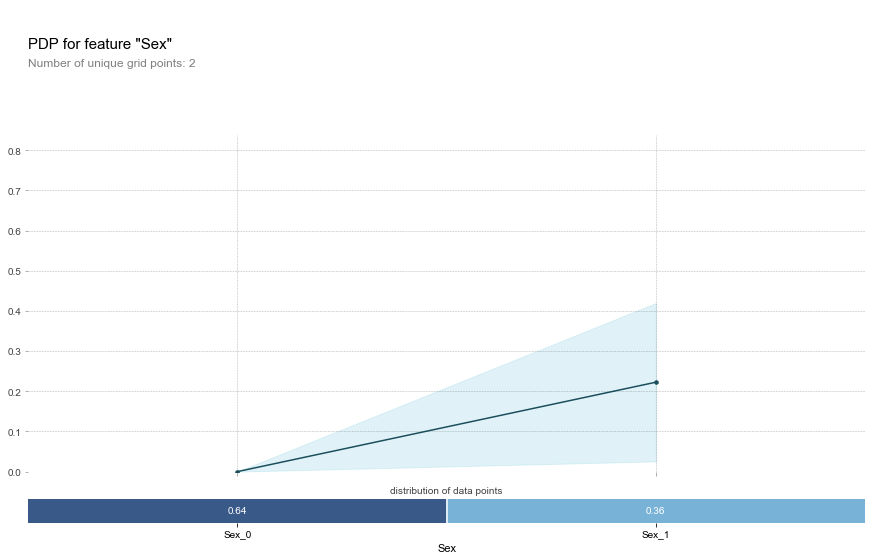

In [35]:
pdp_fare = pdp.pdp_isolate(
    model=random_forest, dataset=X_train, model_features=X_train.columns, feature='Sex'
)
plt.figure
fig, axes = pdp.pdp_plot(pdp_fare, 'Sex', plot_pts_dist=True,plot_lines=False, frac_to_plot=100)

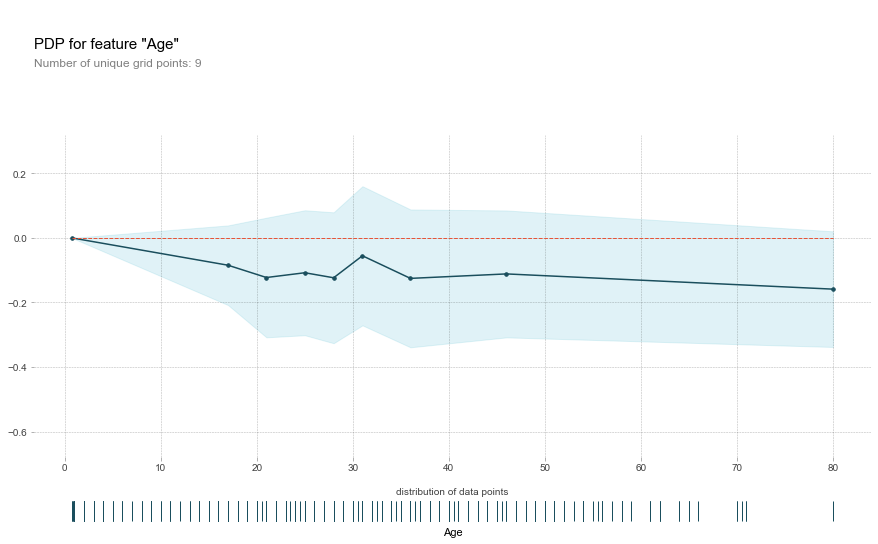

In [29]:
pdp_fare = pdp.pdp_isolate(
    model=random_forest, dataset=X_train, model_features=X_train.columns, feature='Age'
)
plt.figure
fig, axes = pdp.pdp_plot(pdp_fare, 'Age', plot_pts_dist=True)

### Individual interpretations

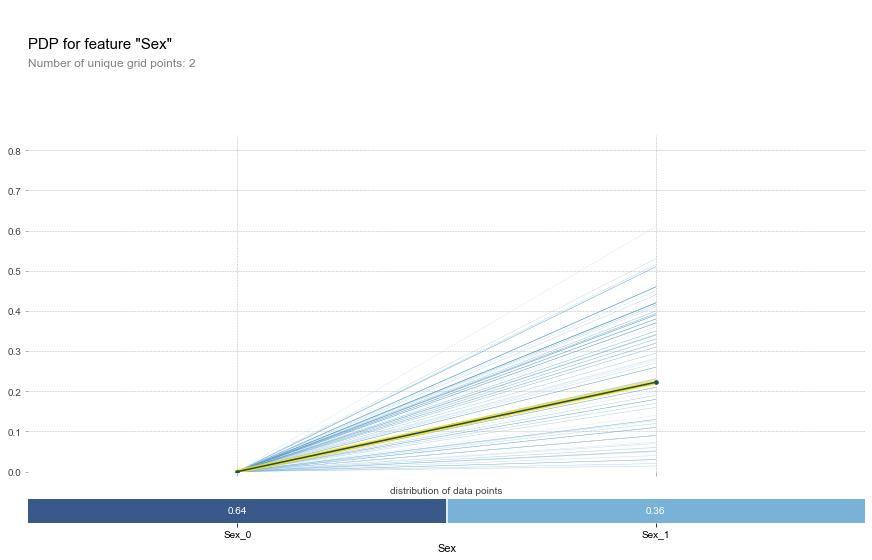

In [36]:
pdp_fare = pdp.pdp_isolate(
    model=random_forest, dataset=X_train, model_features=X_train.columns, feature='Sex'
)
plt.figure
fig, axes = pdp.pdp_plot(pdp_fare, 'Sex', plot_pts_dist=True,plot_lines=True, frac_to_plot=100)

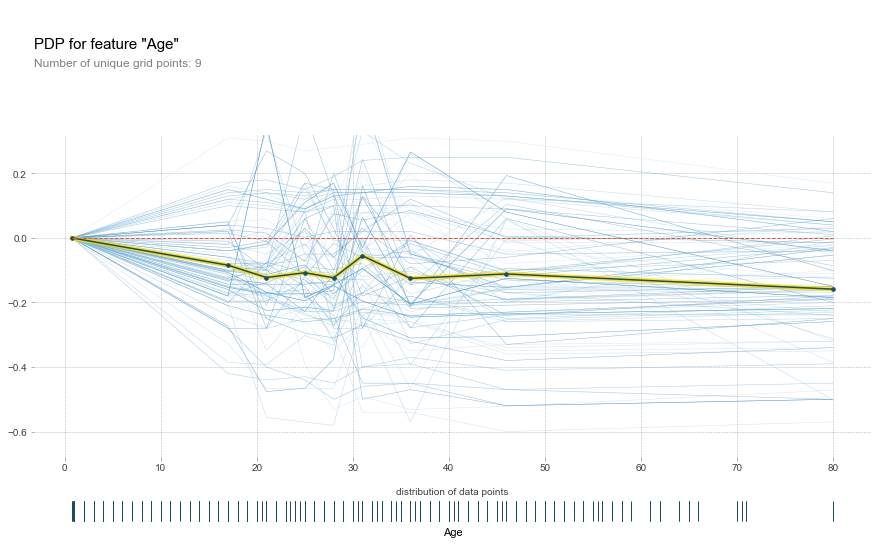

In [34]:
pdp_fare = pdp.pdp_isolate(
    model=random_forest, dataset=X_train, model_features=X_train.columns, feature='Age'
)
plt.figure
fig, axes = pdp.pdp_plot(pdp_fare, 'Age', plot_pts_dist=True,plot_lines=True, frac_to_plot=100)

The fact that ICE is crossing the DPD is a proof of high degree interaction. In that case, the average dependency of that variable with respect to the target might be misleading.

# Sources

- http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html#PDP-and-ICE-plots
- https://compstat-lmu.github.io/iml_methods_limitations/pdp.html
- https://www.youtube.com/watch?v=Q8rTrmqUQsU&t=2116s